In [6]:
# imports
import pandas as pd
import numpy as np
import os
import time
import json
import requests
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
from folium.plugins import HeatMap
from sklearn.cluster import DBSCAN
from sklearn import metrics
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway, normaltest



In [ ]:
# Data Collection
# make sure that you have downloaded the data from the links provided in the README.md file and kept it in the data folder
# load the data

parking_tickets_former = 'data/parking-tickets-2017-2019.csv'
parking_tickets_later = 'data/parking-tickets.csv'
geo_file_path = 'data/geo-locations.csv'
local_area_boundary_path = 'data/local-area-boundary.csv'
downtown_csvs = 'data/downtown/csvs/downtown_parking_tickets'
downtown_combined_heatmap = 'data/downtown/results/downtown_heatmap_all_years.html'
dbscan_combined_heatmap = 'data/downtown/results/dbscan_heatmap_all_years.html'

# adding the google api key directly for project scope
api_key = ""
base_url = "https://maps.googleapis.com/maps/api/geocode/json?"

vancouver_corrds = [49.2827, -123.1207]

data_former = pd.read_csv(parking_tickets_former, sep=';', low_memory=False)
data_later = pd.read_csv(parking_tickets_later, sep=';', low_memory=False)

data_later.drop('BI_ID', axis=1, inplace=True)

# combine the data
data = pd.concat([data_former, data_later], axis=0)

#remove none useful points
data = data[(data['Status'] == 'IS') & ((data['Bylaw'] == 2952) | (data['Bylaw'] == 2849 ))]

# create the directory if it does not exist
output_directory = "data/downtown/results/yearly_heatmaps"
csv_directory = "data/downtown/csvs"

# Create the directory, including any necessary intermediate directories
os.makedirs(output_directory, exist_ok=True)
os.makedirs(csv_directory, exist_ok=True)

In [8]:
# Data Cleaning, Formatting and Preprocessing

# create a full address column for geocoding
data['full_address'] = data['Block'].astype(str) + ' ' + data['Street'] + ', Vancouver, BC, Canada'

if os.path.exists(geo_file_path):
    geo_locations = pd.read_csv(geo_file_path)
else:
    geo_locations = None


In [9]:
# Data Preprocessing: Geocoding the addresses

if geo_locations is None:
    # get unique addresses for geocoding
    unique_addresses = data['full_address'].unique()
    
    # dictionary to store geocoded addresses
    geocode_dict = {
        'full_address': [],
        'latitude': [],
        'longitude': []
    }
    
    # function to geocode address
    def geocode_address(address, api_key):
        params = {
            "address": address,
            "key": api_key
        }
        response = requests.get(base_url, params=params)
        geo_data = response.json()
        if geo_data['status'] == 'OK':
            location = geo_data['results'][0]['geometry']['location']
            return location['lat'], location['lng']
        else:
            return None, None
    
    # geocode each unique address
    for address in unique_addresses:
        lat, lng = geocode_address(address, api_key)
        geocode_dict['full_address'].append(address)
        geocode_dict['latitude'].append(lat)
        geocode_dict['longitude'].append(lng)
        time.sleep(0.1)
    
    # create a DataFrame from the geocode_dict
    geo_locations = pd.DataFrame(geocode_dict)
    
    # save the geocoded data to a CSV file
    geo_locations.to_csv(geo_file_path, index=False)


In [10]:
# Data Preprocessing: Finding the Neighborhoods

# rename columns in geo_locations to avoid conflicts during merge
geo_locations.rename(columns={'latitude': 'geo_latitude', 'longitude': 'geo_longitude'}, inplace=True)

data = data.merge(geo_locations, on='full_address', how='left')

# load the local area boundary data
local_area_boundary = pd.read_csv(local_area_boundary_path, sep=';')

# convert the boundary data to a GeoDataFrame
def parse_geom(geom_str):
    geom = json.loads(geom_str.replace("'", "\""))
    return Polygon(geom['coordinates'][0])

local_area_boundary['geometry'] = local_area_boundary['Geom'].apply(parse_geom)
local_area_boundary_gdf = gpd.GeoDataFrame(local_area_boundary, geometry='geometry', crs="EPSG:4326")

# convert the DataFrame to a GeoDataFrame
data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.geo_longitude, data.geo_latitude), crs="EPSG:4326")

# ensure the local area boundary data has the same CRS
local_area_boundary_gdf = local_area_boundary_gdf.to_crs(data.crs)

# perform spatial join and using predicate parameter to ensure that the points are within the polygons
data_with_neighborhood = gpd.sjoin(data, local_area_boundary_gdf, how="left", predicate="within")

# rename the joined column to 'neighborhood'
data_with_neighborhood.rename(columns={'Name': 'neighborhood'}, inplace=True)

# drop the unnecessary columns
columns_to_drop = ['geometry', 'index_right', 'Geom', 'geo_point_2d']
data_with_neighborhood.drop(columns=columns_to_drop, inplace=True)

data = data_with_neighborhood


In [11]:
# Data Preprocessing: Adding Quarter Information

data['EntryDate'] = pd.to_datetime(data['EntryDate'])

#get the quarter of 
def get_quarter(date):
    month = date.month
    if 1 <= month <= 3:
        return 'Q1'
    elif 4 <= month <= 6:
        return 'Q2'
    elif 7 <= month <= 9:
        return 'Q3'
    elif 10 <= month <= 12:
        return 'Q4'
    else:
        return 'Unknown'
        
data['quarter'] = data['EntryDate'].apply(get_quarter)


In [12]:
# Data Preprocessing: Filtering the Data for Downtown Area

#  separate the data for Downtown and West End into new DataFrames
downtown_data = data[data['neighborhood'] == 'Downtown']
westend_data = data[data['neighborhood'] == 'West End']

# reset indices
downtown_data = downtown_data.reset_index(drop=True)
westend_data = westend_data.reset_index(drop=True)

# merge Downtown and West End data as they are both part of the Downtown area
downtown_data = pd.concat([downtown_data, westend_data], axis=0)

# function to separate the data based on years and create a new CSV file
def separate_data_based_on_year(data, file_path):
    data.to_csv(f"{file_path}_{data['Year'].iloc[0]}.csv", index=False)

# apply the function across the grouped data by year
grouped_data = downtown_data.groupby('Year', group_keys=False)
grouped_data.apply(lambda x: separate_data_based_on_year(x, downtown_csvs))

/tmp/ipykernel_5347/1792175765.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_data.apply(lambda x: separate_data_based_on_year(x, downtown_csvs))


""


Data Availability (% of missing values):
Block              0.000000
Street             0.000000
EntryDate          0.000000
Bylaw              0.000000
Section            0.000000
Status             0.000000
InfractionText    30.157064
Year               0.000000
full_address       0.000000
geo_latitude       0.726628
geo_longitude      0.726628
neighborhood       0.811680
quarter            0.000000
dtype: float64

Rows per Year:
Year
2017    379038
2018    407586
2019    388312
2020    299935
2021    352846
2022    353875
2023    362472
2024    193099
Name: count, dtype: int64


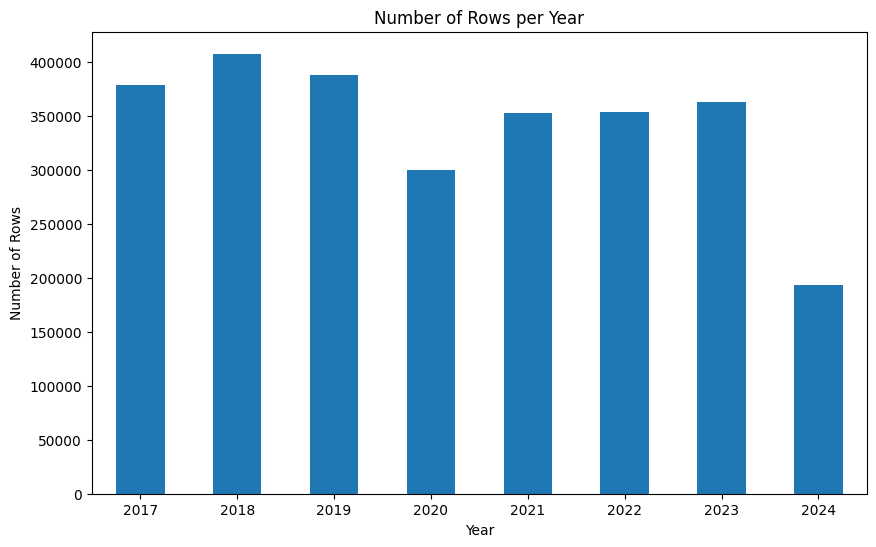


Rows per Neighborhood:
neighborhood
Dunbar-Southlands             7220
Victoria-Fraserview           9091
Oakridge                     14097
West Point Grey              16235
Killarney                    18285
Arbutus Ridge                21051
Shaughnessy                  21493
Kerrisdale                   26954
South Cambie                 27214
Sunset                       27670
Hastings-Sunrise             28093
Marpole                      29186
Renfrew-Collingwood          38572
Kensington-Cedar Cottage     53542
Riley Park                   63069
Grandview-Woodland          109025
Strathcona                  114659
Mount Pleasant              239605
Kitsilano                   259414
West End                    260055
Fairview                    350356
Downtown                    980060
Name: count, dtype: int64


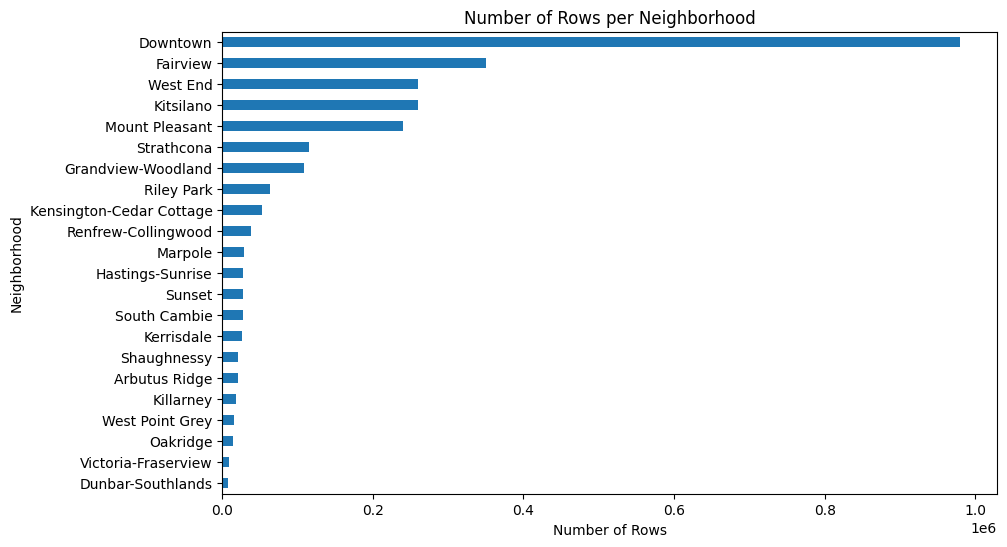

In [13]:
# Data Analysis: Exploratory Data Analysis

# Check data availability
data_availability = data.isnull().sum() / len(data) * 100
print("Data Availability (% of missing values):")
print(data_availability)

# Calculate rows per year
rows_per_year = data['Year'].value_counts().sort_index()
print("\nRows per Year:")
print(rows_per_year)

# plot rows per year
plt.figure(figsize=(10, 6))
rows_per_year.plot(kind='bar')
plt.title('Number of Rows per Year')
plt.ylabel('Number of Rows')
plt.xlabel('Year')
plt.xticks(rotation=0)
plt.show()

# calculate rows per neighborhood
rows_per_neighborhood = data['neighborhood'].value_counts().sort_values()
print("\nRows per Neighborhood:")
print(rows_per_neighborhood)

# plot rows per neighborhood
plt.figure(figsize=(10, 6))
rows_per_neighborhood.plot(kind='barh')
plt.title('Number of Rows per Neighborhood')
plt.xlabel('Number of Rows')
plt.ylabel('Neighborhood')
plt.show()


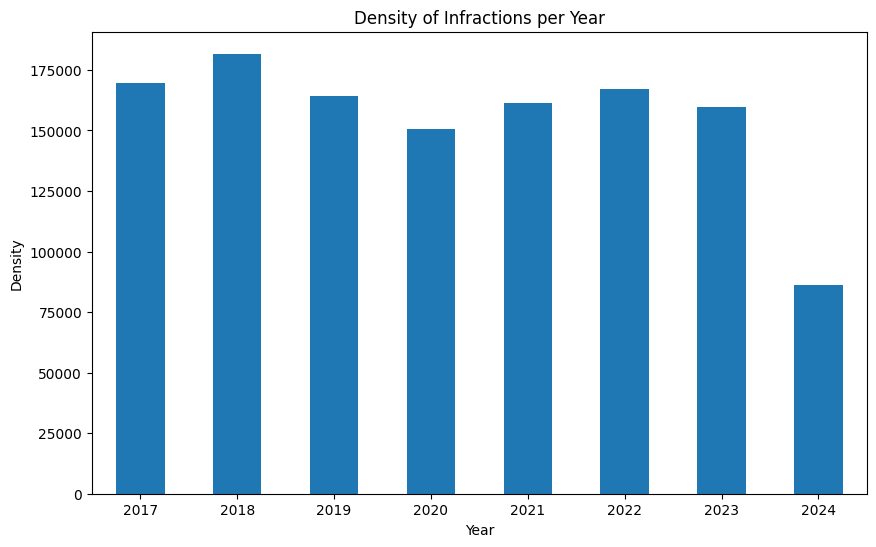

In [14]:
# Data Analysis: Doing Cluster Analysis on the data

years = downtown_data['Year'].unique()
file_paths = pd.Series([f'data/downtown/csvs/downtown_parking_tickets_{year}.csv' for year in years], index=years)

# function to process each year's data
def process_year_data(year):
    file_path = file_paths[year]

    data = pd.read_csv(file_path)
    
    # data cleaning
    data = data.dropna(subset=['geo_latitude', 'geo_longitude'])
    
    # base map centered around Vancouver
    m = folium.Map(location = vancouver_corrds, zoom_start = 13)
    
    # data for the heatmap
    heat_data = data[['geo_latitude', 'geo_longitude']].values.tolist()
    
    # calculate density based on the number of infractions
    density = len(heat_data)
    
    # create and add the heatmap
    heat_map = HeatMap(heat_data, radius=15, blur=10, max_zoom=1)
    m.add_child(heat_map)
    
    # save the map as an HTML file
    m.save(f'data/downtown/results/yearly_heatmaps/downtown_heatmap_{year}.html')
    
    return density

yearly_densities = file_paths.index.to_series().apply(process_year_data)

m = folium.Map(location = vancouver_corrds, zoom_start = 13)
heat_data = downtown_data[['geo_latitude', 'geo_longitude']].dropna().values.tolist()
heat_map = HeatMap(heat_data, radius=15, blur=10, max_zoom=1)
m.add_child(heat_map)
m.save(downtown_combined_heatmap)

# sort the data by year
yearly_densities = yearly_densities.sort_index()

# plot density changes over years
plt.figure(figsize=(10, 6))
yearly_densities.plot(kind='bar')
plt.title('Density of Infractions per Year')
plt.ylabel('Density')
plt.xlabel('Year')
plt.xticks(rotation=0)
plt.show()


In [15]:
# Data Analysis: Doing DBSCAN Clustering on the data

# parameters for DBSCAN
eps = 0.0003 
min_samples = 15 
min_count_threshold = 1500  

# aggregate data by latitude and longitude
combined_data = downtown_data.groupby(['geo_latitude', 'geo_longitude'])['Year'].agg(['count', 'nunique']).reset_index()

# apply DBSCAN clustering on aggregated data
coords = combined_data[['geo_latitude', 'geo_longitude']].values
db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
combined_data['cluster'] = db.labels_

persistent_hotspots = combined_data[
    (combined_data['nunique'] == len(downtown_data['Year'].unique())) & 
    (combined_data['count'] >= min_count_threshold) &
    (combined_data['cluster'] != -1)
]

# function to add a marker for each row
def add_marker(row):
    folium.CircleMarker(
        location=(row['geo_latitude'], row['geo_longitude']),
        radius=7,
        color='red',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

m = folium.Map(location = vancouver_corrds, zoom_start = 13)
persistent_hotspots.apply(add_marker, axis=1)

m.save(dbscan_combined_heatmap)


/home/manvir/sfu/parkingticketsanalysis/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


2017 normaltest: 0.9366460874463812
2018 normaltest: 0.16362423458835637
2019 normaltest: 0.5654870160987786
2020 normaltest: 0.14669612697036158
2021 normaltest: 0.4864532445644285
2022 normaltest: 0.678559250872607
2023 normaltest: 0.453923105362841

One-Way ANOVA Results:
F-statistic: 5.635963343201781
P_value: 6.834310354837896e-05
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
  2017   2018     2379.0 0.8011  -2772.3901  7530.3901  False
  2017   2019   772.8333 0.9993  -4378.5568  5924.2235  False
  2017   2020 -6591.9167  0.004 -11743.3068 -1440.5265   True
  2017   2021 -2182.6667 0.8577  -7334.0568  2968.7235  False
  2017   2022 -2096.9167 0.8793  -7248.3068  3054.4735  False
  2017   2023    -1380.5 0.9831  -6531.8901  3770.8901  False
  2018   2019 -1606.1667  0.964  -6757.5568  3545.2235  False
  2018   2020 -8970.9167    0.0 -14122.306

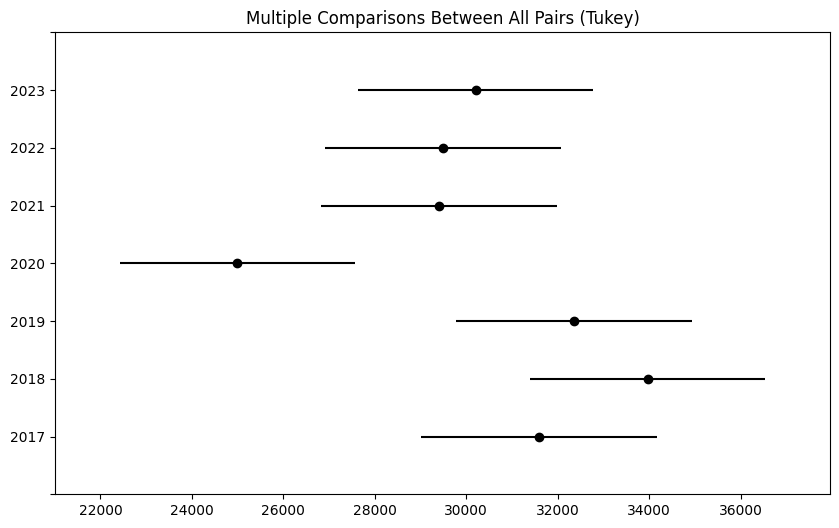

In [16]:
# Data Analysis: Doing ANOVA Testing on the data

#add month to data
data['EntryDate'] = pd.to_datetime(data['EntryDate'])
data['month'] = data['EntryDate'].dt.month


#separate by years
data_2017 = data[(data['Year']==2017)]
data_2018 = data[(data['Year']==2018)]
data_2019 = data[(data['Year']==2019)]
data_2020 = data[(data['Year']==2020)]
data_2021 = data[(data['Year']==2021)]
data_2022 = data[(data['Year']==2022)]
data_2023 = data[(data['Year']==2023)]


#group each data by month for each year

grouped_data_2017 = data_2017.groupby(['month']).size().reset_index(name = 'count')
grouped_data_2018 = data_2018.groupby(['month']).size().reset_index(name = 'count')
grouped_data_2019 = data_2019.groupby(['month']).size().reset_index(name = 'count')
grouped_data_2020 = data_2020.groupby(['month']).size().reset_index(name = 'count')
grouped_data_2021 = data_2021.groupby(['month']).size().reset_index(name = 'count')
grouped_data_2022 = data_2022.groupby(['month']).size().reset_index(name = 'count')
grouped_data_2023 = data_2023.groupby(['month']).size().reset_index(name = 'count')

#check for normality before doing anova testing
print(f"2017 normaltest: {normaltest(grouped_data_2017['count']).pvalue}")
print(f"2018 normaltest: {normaltest(grouped_data_2018['count']).pvalue}")
print(f"2019 normaltest: {normaltest(grouped_data_2019['count']).pvalue}")
print(f"2020 normaltest: {normaltest(grouped_data_2020['count']).pvalue}")
print(f"2021 normaltest: {normaltest(grouped_data_2021['count']).pvalue}")
print(f"2022 normaltest: {normaltest(grouped_data_2022['count']).pvalue}")
print(f"2023 normaltest: {normaltest(grouped_data_2023['count']).pvalue}")
# perform anova testing
f_statistic, p_value = f_oneway(grouped_data_2017['count'], grouped_data_2018['count'],grouped_data_2019['count'],grouped_data_2020['count'],grouped_data_2021['count'],grouped_data_2022['count'],grouped_data_2023['count'])

#
print("\nOne-Way ANOVA Results:")
print(f"F-statistic: {f_statistic}")
print(f"P_value: {p_value}")


x_data = pd.DataFrame({'2017':grouped_data_2017['count'], '2018':grouped_data_2018['count'],'2019':grouped_data_2019['count'],'2020':grouped_data_2020['count'],'2021':grouped_data_2021['count'],'2022':grouped_data_2022['count'],'2023':grouped_data_2023['count']})
x_melt = pd.melt(x_data)
posthoc = pairwise_tukeyhsd(
    x_melt['value'], x_melt['variable'],
    alpha=0.05)

print(posthoc)

fig = posthoc.plot_simultaneous()
